In [24]:
#from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [25]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [26]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [27]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

In [28]:
#!jupyter nbconvert --to script utils_edit_mb.ipynb

In [32]:
s_data = pd.read_csv('./data/train.csv', index_col= 'id')

In [7]:
#s_data_test = pd.read_csv('/Users/m/IDAO2020/Track 1/test.csv', index_col= 'id')

In [33]:
data = get_satellite_data(s_data, 0)
data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [34]:
data.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,13419.744899,19007.658296,30280.477329,-0.849621,2.201501,-2.039018
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,10662.661170,24548.177490,23720.743216,-1.116261,1.715430,-2.636835
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,7182.757625,28395.590633,15553.985280,-1.360095,0.984696,-3.173250
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,3099.591832,29798.085757,6083.094021,-1.536935,-0.033515,-3.544768


In [35]:
data_rtjf = remove_time_jumps_fast(data)
data_rtjf.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t,dt
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0.000000,NaN
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,0.032442,0.032442
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,0.064884,0.032442
3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,0.097326,0.032442
4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,0.129769,0.032442


In [36]:
data_rtjf.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t,dt
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,17269.627379,-2275.948161,39925.025372,-0.084964,2.656988,-0.290960,30.852471,0.032442
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,16696.850918,5166.718053,38337.176299,-0.326478,2.635548,-0.847468,30.884913,0.032442
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946,30.917355,0.032442
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,13419.744899,19007.658296,30280.477329,-0.849621,2.201501,-2.039018,30.949797,0.032442
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,10662.661170,24548.177490,23720.743216,-1.116261,1.715430,-2.636835,30.982239,0.032442


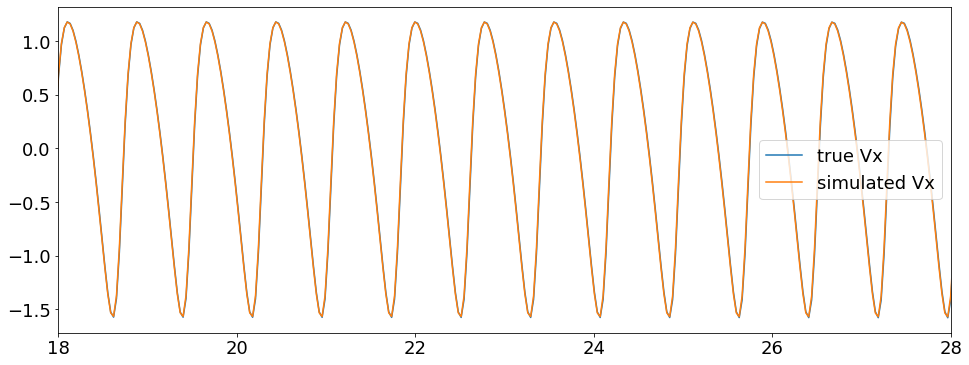

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx');
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx');

plt.xlim([18,28]);
plt.legend();

In [38]:
#run for all satellites and print sat id if error occurs
from tqdm import tqdm
for i in tqdm(range(600)):
    try:
        remove_time_jumps_fast(get_satellite_data(s_data, i))
    except:
        print(i)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 54.00it/s]


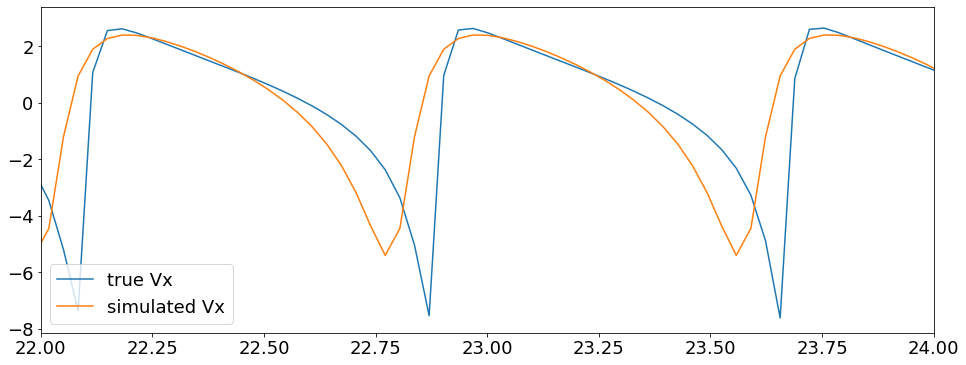

In [41]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 530))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx');
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx');

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([22,24])
plt.legend();

In [42]:
data.shape

(950, 16)

## Explore time scale stretch for simulations

In [51]:
true_feats = ['x','y','z','Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]

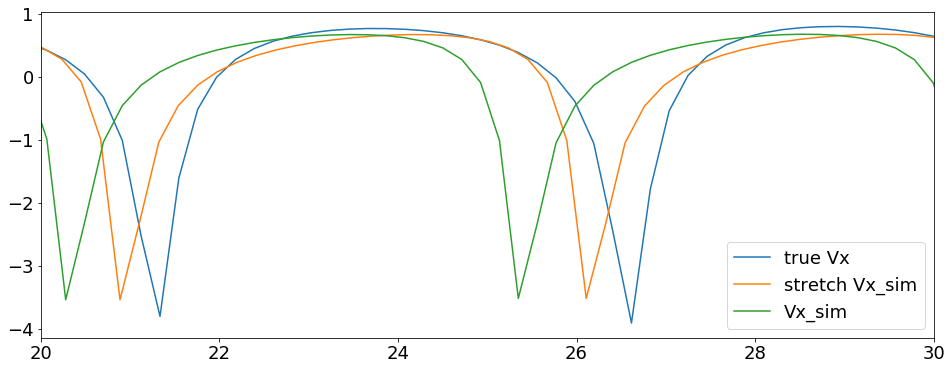

In [213]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 391))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vz'], label = 'true Vx');
plt.plot(1.03*data['t'],data['Vz_sim'], label = 'stretch Vx_sim');
plt.plot(data['t'],data['Vz_sim'], label = 'Vx_sim');

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

In [103]:
smape(data[true_feats].to_numpy(),data[sim_feats].to_numpy())

0.026015160749933878

In [50]:
smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())

0.09474911293928763

In [104]:
def stretch_simulated_feats(data, stretch,true_feats = ['x','y','z','Vx','Vy','Vz'],
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    for feature in true_feats:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

In [211]:
stretch_dict = {}
for sat in tqdm(s_data['sat_id'].unique()):
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.97,1.03,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

100%|██████████| 600/600 [01:11<00:00,  8.38it/s]


In [216]:
extreme_stretch = {k for k,v in stretch_dict.items() if (v <= 0.97 or v >= 1.03)}

In [221]:
for sat in extreme_stretch:
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.92,1.08,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

In [222]:
for sat in extreme_stretch:
    print(sat,stretch_dict[sat])

515 1.0700000000000003
252 0.9500000000000001
556 0.9700000000000001
391 1.0450000000000002


In [49]:
def best_stretch_coefficient(data, threshold = 0.05, iterations = 100,
                            true_feats = ['x','y','z','Vx','Vy','Vz']):
    '''
    find stretch coefficient that yields best smape for given satellite
    iterations: max number of iterations
    
    '''
    

## Checking how LinearAlignment() works

In [44]:
import utils
from LinearAlignment import LinearAlignment

In [122]:
features_list=['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

In [90]:
data = pd.read_csv('data/train.csv')
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)

In [98]:
result_df = []
alignment_model = LinearAlignment()

satellites_list = data['sat_id'].unique()
for sat_id in tqdm(satellites_list):
    pred = pd.DataFrame([])
#     sat_data = utils.get_satellite_data(data, sat_id)
    try:
        sat_data = remove_time_jumps_fast(get_satellite_data(data, sat_id))
#         sat_data = get_satellite_data(data, sat_id) # run to check the smape score before any transformations
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

    n_train = len(sat_data) // 2
    train_sat_data = sat_data[:n_train]
    
    try:
        for feature_name in features_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=train_sat_data[f'{feature_name}_sim'].values,
                                gt=train_sat_data[feature_name].values)
            pred[feature_name] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
        
    sat_sim_smape = utils.smape(sat_data.loc[n_train:, [f'{f}_sim' for f in features_list]].values,
                                sat_data.loc[n_train:, features_list].values)
    sat_new_smape = utils.smape(pred.loc[n_train:, features_list].values,
                                sat_data.loc[n_train:, features_list].values)
    result_df.append([sat_id, sat_sim_smape, sat_new_smape])



  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/600 [00:00<01:44,  5.72it/s]

  0%|▎                                                                                 | 2/600 [00:00<01:55,  5.17it/s]

  0%|▍                                                                                 | 3/600 [00:00<01:51,  5.36it/s]

  1%|▌                                                                                 | 4/600 [00:00<01:42,  5.81it/s]

  1%|▋                                                                                 | 5/600 [00:00<01:46,  5.60it/s]

  1%|▊                                                                                 | 6/600 [00:01<01:49,  5.43it/s]

  1%|▉                                                                                 | 7/600 [00:01<01:48,  5.45it/s]

  1%|█                        

 11%|█████████                                                                        | 67/600 [00:10<01:09,  7.67it/s]

 11%|█████████▏                                                                       | 68/600 [00:11<01:10,  7.54it/s]

 12%|█████████▎                                                                       | 69/600 [00:11<01:11,  7.38it/s]

 12%|█████████▍                                                                       | 70/600 [00:11<01:09,  7.66it/s]

 12%|█████████▌                                                                       | 71/600 [00:11<01:07,  7.89it/s]

 12%|█████████▋                                                                       | 72/600 [00:11<01:09,  7.57it/s]

 12%|█████████▊                                                                       | 73/600 [00:11<01:10,  7.52it/s]

 12%|█████████▉                                                                       | 74/600 [00:11<01:09,  7.54it/s]

 12%|██████████▏                

 22%|█████████████████▊                                                              | 134/600 [00:20<00:59,  7.81it/s]

 22%|██████████████████                                                              | 135/600 [00:20<00:59,  7.83it/s]

 23%|██████████████████▏                                                             | 136/600 [00:20<01:01,  7.51it/s]

 23%|██████████████████▎                                                             | 137/600 [00:20<01:00,  7.62it/s]

 23%|██████████████████▍                                                             | 138/600 [00:20<00:58,  7.89it/s]

 23%|██████████████████▌                                                             | 139/600 [00:21<00:58,  7.89it/s]

 23%|██████████████████▋                                                             | 140/600 [00:21<00:57,  7.94it/s]

 24%|██████████████████▊                                                             | 141/600 [00:21<00:56,  8.14it/s]

 24%|██████████████████▉        

 34%|██████████████████████████▊                                                     | 201/600 [00:29<00:56,  7.02it/s]

 34%|██████████████████████████▉                                                     | 202/600 [00:29<00:54,  7.27it/s]

 34%|███████████████████████████                                                     | 203/600 [00:29<00:52,  7.53it/s]

 34%|███████████████████████████▏                                                    | 204/600 [00:29<00:52,  7.58it/s]

 34%|███████████████████████████▎                                                    | 205/600 [00:29<00:52,  7.53it/s]

 34%|███████████████████████████▍                                                    | 206/600 [00:29<00:50,  7.79it/s]

 34%|███████████████████████████▌                                                    | 207/600 [00:29<00:50,  7.76it/s]

 35%|███████████████████████████▋                                                    | 208/600 [00:30<00:50,  7.81it/s]

 35%|███████████████████████████

linear alignment failed for satellite 252:	ValueError interpolation error, x length = 1,         t_new length = 94




 42%|█████████████████████████████████▊                                              | 254/600 [00:36<00:50,  6.80it/s]

 42%|██████████████████████████████████                                              | 255/600 [00:37<00:50,  6.87it/s]

 43%|██████████████████████████████████▏                                             | 256/600 [00:37<00:48,  7.12it/s]

 43%|██████████████████████████████████▎                                             | 257/600 [00:37<00:47,  7.16it/s]

 43%|██████████████████████████████████▍                                             | 258/600 [00:37<00:48,  7.02it/s]

 43%|██████████████████████████████████▌                                             | 259/600 [00:37<00:49,  6.90it/s]

 43%|██████████████████████████████████▋                                             | 260/600 [00:37<00:46,  7.34it/s]

 44%|██████████████████████████████████▊                                             | 261/600 [00:37<00:44,  7.69it/s]

 44%|█████████████████████████

 54%|██████████████████████████████████████████▊                                     | 321/600 [00:46<00:37,  7.51it/s]

 54%|██████████████████████████████████████████▉                                     | 322/600 [00:46<00:37,  7.48it/s]

 54%|███████████████████████████████████████████                                     | 323/600 [00:46<00:36,  7.63it/s]

 54%|███████████████████████████████████████████▏                                    | 324/600 [00:46<00:36,  7.54it/s]

 54%|███████████████████████████████████████████▎                                    | 325/600 [00:46<00:34,  7.86it/s]

 54%|███████████████████████████████████████████▍                                    | 326/600 [00:46<00:34,  7.86it/s]

 55%|███████████████████████████████████████████▌                                    | 327/600 [00:47<00:33,  8.06it/s]

 55%|███████████████████████████████████████████▋                                    | 328/600 [00:47<00:33,  8.01it/s]

 55%|███████████████████████████

 65%|███████████████████████████████████████████████████▋                            | 388/600 [00:56<00:32,  6.46it/s]

 65%|███████████████████████████████████████████████████▊                            | 389/600 [00:56<00:30,  6.84it/s]

 65%|████████████████████████████████████████████████████                            | 390/600 [00:56<00:29,  7.08it/s]

 65%|████████████████████████████████████████████████████▏                           | 391/600 [00:57<00:29,  7.00it/s]

 65%|████████████████████████████████████████████████████▎                           | 392/600 [00:57<00:28,  7.37it/s]

 66%|████████████████████████████████████████████████████▍                           | 393/600 [00:57<00:27,  7.40it/s]

 66%|████████████████████████████████████████████████████▌                           | 394/600 [00:57<00:30,  6.69it/s]

 66%|████████████████████████████████████████████████████▋                           | 395/600 [00:57<00:30,  6.78it/s]

 66%|███████████████████████████

 76%|████████████████████████████████████████████████████████████▋                   | 455/600 [01:05<00:19,  7.54it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 456/600 [01:05<00:18,  7.78it/s]

 76%|████████████████████████████████████████████████████████████▉                   | 457/600 [01:05<00:18,  7.83it/s]

 76%|█████████████████████████████████████████████████████████████                   | 458/600 [01:05<00:17,  8.09it/s]

 76%|█████████████████████████████████████████████████████████████▏                  | 459/600 [01:06<00:17,  8.12it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 460/600 [01:06<00:17,  7.97it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 461/600 [01:06<00:17,  7.83it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 462/600 [01:06<00:18,  7.53it/s]

 77%|███████████████████████████

 87%|█████████████████████████████████████████████████████████████████████▌          | 522/600 [01:14<00:10,  7.33it/s]

 87%|█████████████████████████████████████████████████████████████████████▋          | 523/600 [01:14<00:10,  7.50it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 524/600 [01:14<00:10,  7.09it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 525/600 [01:15<00:10,  7.25it/s]

 88%|██████████████████████████████████████████████████████████████████████▏         | 526/600 [01:15<00:10,  7.39it/s]

 88%|██████████████████████████████████████████████████████████████████████▎         | 527/600 [01:15<00:09,  7.48it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 528/600 [01:15<00:09,  7.20it/s]

 88%|██████████████████████████████████████████████████████████████████████▌         | 529/600 [01:15<00:09,  7.56it/s]

 88%|███████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 589/600 [01:23<00:01,  6.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 590/600 [01:24<00:01,  6.95it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 591/600 [01:24<00:01,  7.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 592/600 [01:24<00:01,  7.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 593/600 [01:24<00:00,  7.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 594/600 [01:24<00:00,  7.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 595/600 [01:24<00:00,  7.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 596/600 [01:24<00:00,  7.53it/s]

100%|███████████████████████████

In [101]:
result_df = pd.DataFrame(result_df, columns=['sat_id', 'sat_simulation_smape', 'sat_new_smape'])

In [102]:
set(satellites_list).difference(set(result_df['sat_id'].unique()))

{252}

In [103]:
print(f'{len(result_df)}/{len(satellites_list)} satellites processed')
print('\nmetrics:', dict(result_df.iloc[:, 1:].mean()))

599/600 satellites processed

metrics: {'sat_simulation_smape': 0.14499453179384694, 'sat_new_smape': 0.081452639182849}


## Transforming all the data

In [114]:
transf_df = pd.DataFrame([])
for sat_id in tqdm(satellites_list):
    pred = pd.DataFrame([])
#     sat_data = utils.get_satellite_data(data, sat_id)
    try:
        sat_data = remove_time_jumps_fast(get_satellite_data(data, sat_id))
#         sat_data = get_satellite_data(data, sat_id) # run to check the smape score before any transformations
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

    n_train = len(sat_data) // 2
    train_sat_data = sat_data[:n_train]
    
    try:
        for feature_name in features_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=train_sat_data[f'{feature_name}_sim'].values,
                                gt=train_sat_data[feature_name].values)
            pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            pred['sat_id'] = sat_id
            
    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    transf_df = transf_df.append(pred)



  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/600 [00:00<01:38,  6.10it/s]

  0%|▎                                                                                 | 2/600 [00:00<01:48,  5.49it/s]

  0%|▍                                                                                 | 3/600 [00:00<01:51,  5.36it/s]

  1%|▌                                                                                 | 4/600 [00:00<01:45,  5.65it/s]

  1%|▋                                                                                 | 5/600 [00:00<01:46,  5.58it/s]

  1%|▊                                                                                 | 6/600 [00:01<01:46,  5.56it/s]

  1%|▉                                                                                 | 7/600 [00:01<01:43,  5.71it/s]

  1%|█                        

 11%|█████████                                                                        | 67/600 [00:14<01:48,  4.90it/s]

 11%|█████████▏                                                                       | 68/600 [00:14<01:48,  4.89it/s]

 12%|█████████▎                                                                       | 69/600 [00:15<01:48,  4.89it/s]

 12%|█████████▍                                                                       | 70/600 [00:15<01:46,  4.97it/s]

 12%|█████████▌                                                                       | 71/600 [00:15<01:46,  4.98it/s]

 12%|█████████▋                                                                       | 72/600 [00:15<01:46,  4.97it/s]

 12%|█████████▊                                                                       | 73/600 [00:15<01:46,  4.97it/s]

 12%|█████████▉                                                                       | 74/600 [00:16<01:46,  4.94it/s]

 12%|██████████▏                

 22%|█████████████████▊                                                              | 134/600 [00:30<02:13,  3.50it/s]

 22%|██████████████████                                                              | 135/600 [00:30<02:10,  3.56it/s]

 23%|██████████████████▏                                                             | 136/600 [00:30<02:16,  3.40it/s]

 23%|██████████████████▎                                                             | 137/600 [00:31<02:19,  3.31it/s]

 23%|██████████████████▍                                                             | 138/600 [00:31<03:05,  2.49it/s]

 23%|██████████████████▌                                                             | 139/600 [00:32<02:55,  2.63it/s]

 23%|██████████████████▋                                                             | 140/600 [00:32<02:45,  2.78it/s]

 24%|██████████████████▊                                                             | 141/600 [00:32<02:32,  3.01it/s]

 24%|██████████████████▉        

 34%|██████████████████████████▊                                                     | 201/600 [00:55<03:56,  1.69it/s]

 34%|██████████████████████████▉                                                     | 202/600 [00:55<03:39,  1.82it/s]

 34%|███████████████████████████                                                     | 203/600 [00:56<03:33,  1.86it/s]

 34%|███████████████████████████▏                                                    | 204/600 [00:56<03:23,  1.95it/s]

 34%|███████████████████████████▎                                                    | 205/600 [00:57<03:09,  2.08it/s]

 34%|███████████████████████████▍                                                    | 206/600 [00:57<03:12,  2.05it/s]

 34%|███████████████████████████▌                                                    | 207/600 [00:58<03:23,  1.93it/s]

 35%|███████████████████████████▋                                                    | 208/600 [00:58<03:17,  1.98it/s]

 35%|███████████████████████████

linear alignment failed for satellite 252:	ValueError interpolation error, x length = 1,         t_new length = 94




 42%|█████████████████████████████████▊                                              | 254/600 [01:21<03:18,  1.74it/s]

 42%|██████████████████████████████████                                              | 255/600 [01:22<04:15,  1.35it/s]

 43%|██████████████████████████████████▏                                             | 256/600 [01:23<04:21,  1.31it/s]

 43%|██████████████████████████████████▎                                             | 257/600 [01:24<04:08,  1.38it/s]

 43%|██████████████████████████████████▍                                             | 258/600 [01:24<03:49,  1.49it/s]

 43%|██████████████████████████████████▌                                             | 259/600 [01:25<03:38,  1.56it/s]

 43%|██████████████████████████████████▋                                             | 260/600 [01:25<03:26,  1.65it/s]

 44%|██████████████████████████████████▊                                             | 261/600 [01:26<03:17,  1.72it/s]

 44%|█████████████████████████

 54%|██████████████████████████████████████████▊                                     | 321/600 [02:02<03:28,  1.34it/s]

 54%|██████████████████████████████████████████▉                                     | 322/600 [02:03<03:36,  1.29it/s]

 54%|███████████████████████████████████████████                                     | 323/600 [02:03<03:25,  1.35it/s]

 54%|███████████████████████████████████████████▏                                    | 324/600 [02:04<03:28,  1.33it/s]

 54%|███████████████████████████████████████████▎                                    | 325/600 [02:05<03:36,  1.27it/s]

 54%|███████████████████████████████████████████▍                                    | 326/600 [02:06<03:54,  1.17it/s]

 55%|███████████████████████████████████████████▌                                    | 327/600 [02:07<04:11,  1.09it/s]

 55%|███████████████████████████████████████████▋                                    | 328/600 [02:08<03:54,  1.16it/s]

 55%|███████████████████████████

 65%|███████████████████████████████████████████████████▋                            | 388/600 [02:56<02:29,  1.42it/s]

 65%|███████████████████████████████████████████████████▊                            | 389/600 [02:58<02:51,  1.23it/s]

 65%|████████████████████████████████████████████████████                            | 390/600 [02:59<03:58,  1.14s/it]

 65%|████████████████████████████████████████████████████▏                           | 391/600 [03:02<05:17,  1.52s/it]

 65%|████████████████████████████████████████████████████▎                           | 392/600 [03:04<06:09,  1.78s/it]

 66%|████████████████████████████████████████████████████▍                           | 393/600 [03:06<06:30,  1.89s/it]

 66%|████████████████████████████████████████████████████▌                           | 394/600 [03:08<05:48,  1.69s/it]

 66%|████████████████████████████████████████████████████▋                           | 395/600 [03:09<05:04,  1.48s/it]

 66%|███████████████████████████

 76%|████████████████████████████████████████████████████████████▋                   | 455/600 [04:01<02:30,  1.03s/it]

 76%|████████████████████████████████████████████████████████████▊                   | 456/600 [04:02<02:30,  1.04s/it]

 76%|████████████████████████████████████████████████████████████▉                   | 457/600 [04:03<02:23,  1.00s/it]

 76%|█████████████████████████████████████████████████████████████                   | 458/600 [04:04<02:25,  1.02s/it]

 76%|█████████████████████████████████████████████████████████████▏                  | 459/600 [04:05<02:18,  1.02it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 460/600 [04:05<02:13,  1.05it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 461/600 [04:06<02:11,  1.05it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 462/600 [04:08<02:22,  1.03s/it]

 77%|███████████████████████████

 87%|█████████████████████████████████████████████████████████████████████▌          | 522/600 [05:10<01:39,  1.27s/it]

 87%|█████████████████████████████████████████████████████████████████████▋          | 523/600 [05:12<01:46,  1.39s/it]

 87%|█████████████████████████████████████████████████████████████████████▊          | 524/600 [05:14<02:14,  1.78s/it]

 88%|██████████████████████████████████████████████████████████████████████          | 525/600 [05:17<02:38,  2.11s/it]

 88%|██████████████████████████████████████████████████████████████████████▏         | 526/600 [05:18<02:13,  1.81s/it]

 88%|██████████████████████████████████████████████████████████████████████▎         | 527/600 [05:20<02:02,  1.67s/it]

 88%|██████████████████████████████████████████████████████████████████████▍         | 528/600 [05:22<02:03,  1.72s/it]

 88%|██████████████████████████████████████████████████████████████████████▌         | 529/600 [05:25<02:45,  2.34s/it]

 88%|███████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 589/600 [06:26<00:10,  1.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 590/600 [06:27<00:09,  1.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 591/600 [06:27<00:08,  1.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 592/600 [06:28<00:07,  1.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 593/600 [06:29<00:06,  1.15it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 594/600 [06:30<00:05,  1.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 595/600 [06:31<00:04,  1.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 596/600 [06:32<00:03,  1.08it/s]

100%|███████████████████████████

In [139]:
transf_df = transf_df.drop(columns = features_list, axis = 1)

KeyError: "['x' 'y' 'z' 'Vx' 'Vy' 'Vz'] not found in axis"

In [134]:
transf_df.head()

,Vx_sim,Vy_sim,Vz_sim,sat_id,x_sim,y_sim,z_sim
0,-0.907527,-3.804930,-2.024133,0,-8843.131454,13138.221690,-20741.615306
1,-0.303785,-4.269804,-0.616680,0,-10555.383233,1650.965573,-24472.853186
2,0.274742,-4.046934,0.718414,0,-10572.073071,-10142.753466,-24271.731709
3,0.712295,-3.375559,1.717947,0,-9150.464665,-20614.215628,-20767.054522
4,0.989273,-2.523141,2.341966,0,-6730.920362,-28898.299742,-14996.096980


In [140]:
new = pd.merge(transf_df, data[features_list+['sat_id']], how='inner', on='sat_id', 
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False)

MemoryError: Unable to allocate 10.6 GiB for an array with shape (1419756354,) and data type int64

In [130]:
d = data[features_list+['sat_id']]
d.shape

(649912, 7)

In [131]:
transf_df.shape

(649818, 13)

In [136]:
d.head()

,x,y,z,Vx,Vy,Vz,sat_id
0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,0
1,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,0
2,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,0
3,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,0
4,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,0


In [137]:
d.join(transf_df, on = 'sat_id')

ValueError: columns overlap but no suffix specified: Index(['sat_id'], dtype='object')